In [3]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [4]:
df = pd.read_csv('Validation error of 501 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,0.0,inf,17.433472,-6.122959,24.160230,65.100247,-19.914555,7.592000e+26,0.000000,...,-23.793379,-2.302585,-13.047982,7.592000e+26,459.837735,-6.910237,9.844557e+07,-29.541915,-3.801574,-10.449535
1,0,-0.0,-51.227594,-9.266645,-1.551450,-6.298893,15.413347,14.287386,-2.530667e+26,1111.111112,...,-20.211580,-5.884385,-23.793379,-2.530667e+26,541.915625,-21.588532,4.970793e+07,-18.938475,-6.791365,-27.192831
2,0,0.0,-30.198242,1.990493,-6.679057,10.005600,91.067713,-32.023554,7.592000e+26,222.222209,...,-20.211580,-2.302585,-27.375179,7.592000e+26,155.115008,-9.654607,7.756502e+07,-22.233870,-4.399497,-18.608674
3,0,0.0,-11.838667,19.281076,-8.981104,10.878345,6.948953,42.970569,1.265333e+27,666.666657,...,-27.375179,-20.211580,-20.211580,1.265333e+27,587.742209,-7.018957,1.626157e+07,-30.353145,-21.616074,-28.896611
4,0,-0.0,-65.828596,-4.516934,-8.230240,3.610617,1.144615,-20.774122,-2.530667e+26,1555.555582,...,-16.629781,-13.047982,-20.211580,-2.530667e+26,531.555176,-22.718648,7.627573e+07,-17.230219,-13.197332,-16.012802


In [5]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,...,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.000000
mean,0.0,0.0,NaN,5.904707,-3.718273,5.008021,11.011039,19.369362,1.524474e+27,1016.888890,...,-18.442172,-18.241591,-17.711485,1.524474e+27,908.492402,-17.728021,5.271097e+07,-18.443292,-18.752955,-16.843099
std,0.0,0.0,NaN,27.756311,17.761804,15.877125,27.314630,126.228980,1.484884e+27,651.585684,...,10.380275,10.094948,10.248685,1.484884e+27,562.114524,9.109199,3.226598e+07,9.693230,9.525446,8.622615
min,0.0,0.0,-inf,-68.637654,-57.315314,-33.320846,-82.562494,-94.557822,-7.592000e+26,0.000000,...,-34.538777,-34.538777,-34.538777,-7.592000e+26,-328.473210,-34.371933,2.984129e+06,-35.532397,-35.817946,-35.066641
25%,0.0,0.0,-55.494795,-4.903546,-12.318223,-2.803747,-1.469802,-20.638815,2.530666e+26,444.444418,...,-27.375179,-27.375179,-27.375179,2.530666e+26,472.810909,-25.723569,2.260745e+07,-26.740057,-27.770940,-24.308641
50%,0.0,0.0,-12.291373,-0.619342,-4.365564,2.097599,3.890374,-3.541753,1.265333e+27,1111.111112,...,-20.211580,-16.629781,-16.629781,1.265333e+27,881.043188,-17.705721,5.193699e+07,-19.595510,-18.815520,-17.408042
75%,0.0,0.0,86.461913,5.256674,0.321456,9.318562,11.087573,20.800669,2.783733e+27,1555.555582,...,-9.466183,-9.466183,-9.466183,2.783733e+27,1398.998410,-9.632264,8.174890e+07,-10.145793,-10.441406,-8.902093
max,0.0,0.0,inf,191.035372,99.989563,121.638074,202.533174,1326.600790,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,3.796000e+27,2189.499378,-1.895024,1.114710e+08,-1.719632,-2.536768,-0.125311


ValueError: supplied range of [-inf, inf] is not finite

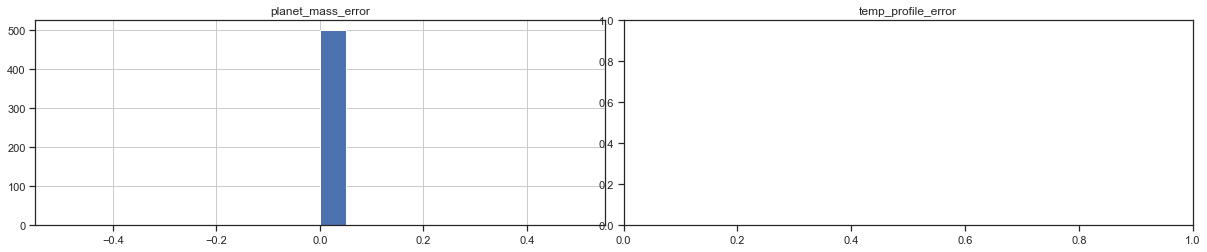

In [6]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

In [ ]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2)
    plt.plot(y_hat, y, '.')
    #plt.ylim(plt.xlim()) # set y axis range the same as x axis range
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xlabel(r"$\hat{y}$")
    plt.ylabel(r"$y$")
    plt.grid()
    plt.tight_layout()

In [ ]:
# Error per parameter

In [ ]:
params

In [ ]:
param = params[6]
print('Param: ', param)

uniques = df[param+'_real'].unique()
print('Uniques: ',uniques)

In [ ]:
counts = []
stds = []
for unique in uniques:
    t = df[param+'_error'][(df[param+'_real'] == unique)]
    std = t.std()
    count = t.count()
    print(count, std)
    
    counts.append(count)
    stds.append(std)
    
plt.plot(uniques, stds, '.')
plt.grid()
plt.xlabel('uniques')
plt.ylabel('stds')

In [ ]:
params